# Unravelling the complex interplay between environmental drivers and conflict

This notebook contains a already relatively mature pipeline to assess the accuracy of different scale- and modelalgorithms.

**Note:** This notbook is under constant development. Please be aware of the version number of the conflict model used in each of the notebooks.

In its current form, we first make a selection of conflicts to be used for training and testing the model. Selection criteria are amongst others minimum number of fatalities and climate zones. Subsequently, annual statistics (now: mean) of a range of environmental variables are determined per geographic unit (now: water provinces) and stored along with a 0/1 conflict value. The number of variables to be sampled is flexible and can be easily adapted in the cfg-file. 

This dataset is subsequently scaled, split, and applied in a machine learning model. Since there are various ways out there to scale your data and then fit and predict, the notebook is designed such that a variable amount of scalers and models can be specified. All possible combinations of scaler and model are then evaluated and output saved to an output directory.

All model settings need to be defined in the run_settings.cfg file.

For questions, please contact J.M. Hoch (j.m.hoch@uu.nl).

With contributions from N. Wanders (Utrecht University) and S. de Bruin (PBL).

## Import libraries and file with settings

Import all required python packages for this notebook.

In [1]:
import conflict_model

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import csv
import netCDF4 as nc
import rasterstats as rstats
import xarray as xr
import rasterio as rio
import seaborn as sbs
from sklearn import svm, neighbors, naive_bayes, preprocessing, model_selection, metrics, utils
import os, sys

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
conflict_model.utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
conflict_model version: 0.0.3b4
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.22.1
matplotlib version: 3.2.1
seaborn version: 0.10.1
rasterstats version: 0.14.0


In this file all the settings for the analysis are defined. By 'parsing' it, all values are read for different sections. This is a simple way to make the code independent of the input data and settings.

In [3]:
settings_file = r'../data/run_setting.cfg'

Based on this settings-file, the set-up of the run can be initialized.

In [4]:
config, out_dir = conflict_model.utils.initiate_setup(settings_file)

for the record, saving output to folder C:\Users\hoch0001\Documents\_code\conflict_model\data\OUT


# Filter conflicts

Not all conflicts of the database should be used for the model. This can be, for example, because they belong to a non-relevant type of conflict we are not interested in, or because it is very likely that the conflict is not water-related.

First, get the conflict data base and convert it into a georeferenced dataframe. This is needed for all following steps where this data is combined with other data sources.

In [5]:
gdf = conflict_model.utils.get_geodataframe(config)

reading csv file to dataframe C:\Users\hoch0001\Documents\_code\conflict_model\data\UCDP/ged201.csv


C:\Users\hoch0001\AppData\Local\Continuum\anaconda3\envs\conflict_model\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


...DONE

translating to geopandas dataframe
...DONE



Second, get the subset of conflicts based on user-defined conditions in the settings file. To filter out non-water-related conflicts, we use only those conflicts falling in climate zones notoriously known for water shortages.

In [6]:
conflict_gdf, extent_gdf, extent_active_polys_gdf, global_df = conflict_model.selection.select(gdf, config)

filtering on conflict properties...
...filtering key best with lower value 1
...filtering key type_of_violence with value(s) ['1', '2', '3']
focussing on period between 2000 and 2015

reading extent and spatial aggregation level from file C:\Users\hoch0001\Documents\_code\conflict_model\data\waterProvinces/waterProvinces_Africa.shp
...DONE

fixing invalid geometries
...DONE

clipping clipping conflict dataset to extent
...DONE

clipping conflicts to climate zones ['BWh', 'BSh']
...DONE

clipping polygons to climate zones ['BWh', 'BSh']
...DONE



Have a brief glimpse at the spatial distribution of the selected conflicts. As background map, we use all water provinces to give it a nicer visual expression.

Depending on the settings, we may focus on some climate zones only. As such, not all water provinces are used in the model. For a visual inspection if this selection worked as intended, we plot below the conflicts and as background map only those water provinces that are actually used in the model.

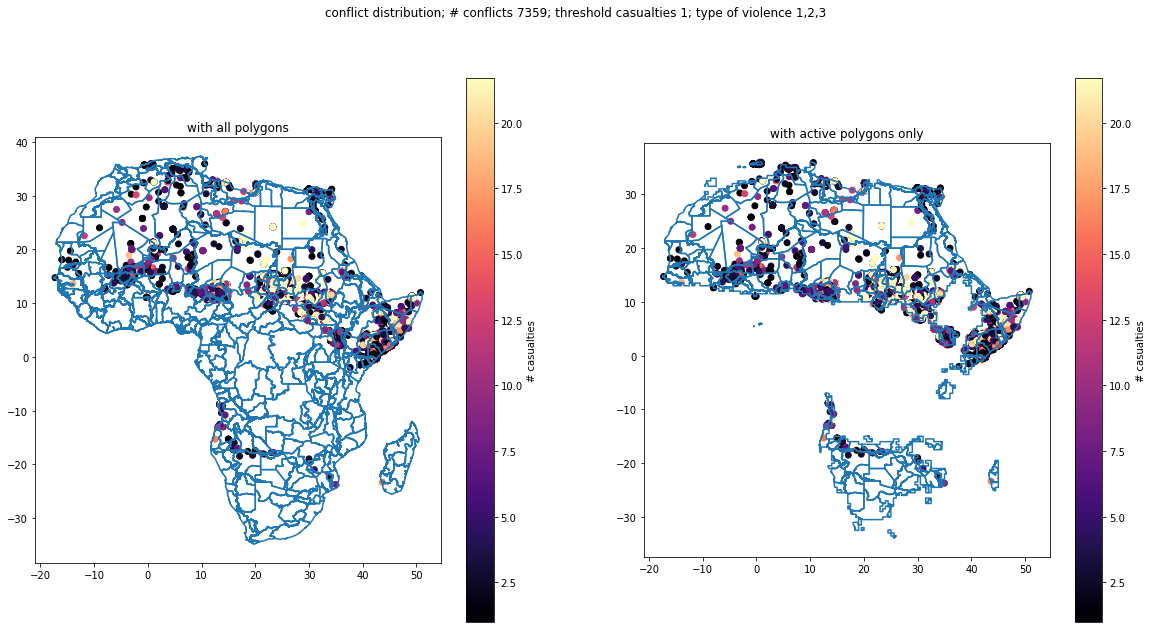

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('conflict distribution; # conflicts {}; threshold casualties {}; type of violence {}'.format(len(conflict_gdf), config.get('conflict', 'min_nr_casualties'), config.get('conflict', 'type_of_violence')))

conflict_gdf.plot(ax=ax1, c='r', column='best', cmap='magma', vmin=int(config.get('conflict', 'min_nr_casualties')), vmax=conflict_gdf.best.mean(), legend=True, legend_kwds={'label': "# casualties",})
extent_gdf.boundary.plot(ax=ax1)
ax1.set_title('with all polygons')

conflict_gdf.plot(ax=ax2, c='r', column='best', cmap='magma', vmin=int(config.get('conflict', 'min_nr_casualties')), vmax=conflict_gdf.best.mean(), legend=True, legend_kwds={'label': "# casualties",})
extent_active_polys_gdf.boundary.plot(ax=ax2)
ax2.set_title('with active polygons only')
                         
plt.savefig(os.path.join(out_dir, 'conflict_and_casualties_distribution.png'), dpi=300)

# Analysis per year

This is an essential part of the code. Here, we go through all model years as specified in the settings-file and do the following:

1. Get a 0/1 classifier whether a conflict took place in a geographical unit or not;
2. Loop through various files with environmental variables and get mean variable value per geographical unit.

This is all stored in a dictionary for easy processing. We first need to initialize this dictionary containing a pandas Series per provided environmental variable. To keep this automated, each 'key' in the section 'env_var' in the cfg-file should be equal to the variable name used on the corresponding nc-file. Then, add a pandas Series for the conflict data.

In [8]:
XY = conflict_model.data.initiate_XY_data(config)
XY

{'poly_ID': Series([], dtype: float64),
 'poly_geometry': Series([], dtype: float64),
 'GDP_per_capita_PPP': Series([], dtype: float64),
 'total_evaporation': Series([], dtype: float64),
 'precipitation': Series([], dtype: float64),
 'surface_water_storage': Series([], dtype: float64),
 'upper_soil_storage': Series([], dtype: float64),
 'groundwater_recharge': Series([], dtype: float64),
 'temperature': Series([], dtype: float64),
 'int_grazing': Series([], dtype: float64),
 'ext_grazing': Series([], dtype: float64),
 'irr_water_demand': Series([], dtype: float64),
 'governanceIndex': Series([], dtype: float64),
 'conflict': Series([], dtype: int32)}

Now let's go through all years and all files and data and assign the values to the corresponding Series in the dictionary.

In [9]:
%%capture

XY = conflict_model.data.fill_XY(XY, config, conflict_gdf, extent_active_polys_gdf)

# Machine Learning

## Data preparation

Before we can get started, we have to prepare the sampled data such that it is compatible with the Machine Learning (ML) models.

First, create a pandas dataframe from the dictionary and kick out rows with missing values as they do not work with ML models.

Then, we convert them to numpy arrays, separately for the variables (X) and the target conflict (Y).

In [10]:
X, Y = conflict_model.data.split_XY_data(XY)

number of data points including missing values: 4110
number of data points excluding missing values: 4005


### Target evaluation

Let's have a closer look at what we actualy work with. This is essential to select and tune the right ML model, for instance.

In [11]:
print('the total number of data points for our target is', len(Y))

the total number of data points for our target is 4005


In [12]:
fraction_Y_1 = 100*len(np.where(Y != 0)[0])/len(Y)

In [13]:
print('from this, {0} points are equal to 1, i.e. represent conflict occurence. This is a fraction of {1} percent.'.format(len(np.where(Y != 0)[0]), round(fraction_Y_1, 2)))

from this, 619 points are equal to 1, i.e. represent conflict occurence. This is a fraction of 15.46 percent.


We see that only a very small amout of conflicts are sampled. This small fraction compared to the vast amoutn of non-conflicts indicates we have an **imbalanced problem** and thus will need to account for this in the settings of the model used and data pre-processing.

## ML modelling pipeline

This pipeline allows to combine various scalers and models to find the best-performing combination and assess sensitivities.

### Data pre-processing

Before we can train and predict with the model, we need to scale the variable data. This is required because our input data has a range of units (or not) and values vary in orders of magnitude. 

Besides, it is important to create separate training- and testdata for both variables and target.

#### Scaler

Depending on which scaler is chosen, the standardization of the data follows different approaches and may eventually influence model results. See here for some info: https://scikit-learn.org/stable/modules/preprocessing.html and https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html.

The scaler is then used to fit the data and transform it according to scaler-specific method. I don't scale Y since it is either 0 or 1 already.

The scaled variable data X_scaled is, together with the target data Y, split into trainings and test data. The fraction of the total data that is used for training is user-defined.

The scatterplot of the first two variables in X_train looks like this. Also the sample size n_train is provided used to train the data alongside with the total variable sample size n_tot.

In [14]:
scalers = conflict_model.machine_learning.define_scaling(config)

chosen scaling method is QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=42,
                    subsample=100000)


### Models

The variety of ML models is sheer endless. We here use two models for supervised learning which showed better performance than other candidates in previous assessment rounds. Also, all model parameters were already calibrated using GridSearchCV in previous analyses.

In [15]:
clfs = conflict_model.machine_learning.define_model(config)

chosen ML model is KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')


### The model pipeline

The model pipeline starts with **splitting the data in scaled train and test samples**. 

It then contains a number of steps which are performed for each scaler-model combination, explained hereafter.

#### ***k-fold cross-validation***

It is important to check how robust the models are in terms of accuracy as well as under- and overfitting. To that end, we apply **cross-validation (CV)** to fit the training-data against each other by splitting it up in chunks (as defined by k) and one chunk against all other k-1 chunks. k is 10 in our case, the default value is 5.

#### ***Model fitting and prediction***

Subsequently, we fit the models based on the training-data. With a fitted model, we can predict our target based on the remaining test-data.


All these steps are placed into functions and are step-wise called from a master function:

In [16]:
y_df, y_gdf = conflict_model.model.run(X, Y, config, scalers, clfs, out_dir)

### USING ALL DATA ###

Accuracy: 0.898
Precision: 0.708
Recall: 0.520
F1 score: 0.599
Brier loss score: 0.078
Cohen-Kappa score: 0.542

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1025
           1       0.71      0.52      0.60       177

    accuracy                           0.90      1202
   macro avg       0.81      0.74      0.77      1202
weighted avg       0.89      0.90      0.89      1202




#### ***Evaluation***

We have now produced a set of predictions, y_pred. This can be comapred with the retained test-targets y_test to evaluate the prediction. There are many ways to do this and several are applied here.

The **accuracy** is either the fraction (default) or the count (normalize=False) of correct predictions.

The **precision** is the ratio *tp / (tp + fp)* where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The **recall** is the ratio *tp / (tp + fn)* where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The main classification metrics are nicely summarized in the **classification report**:

**Precision-Recall** is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

Another nice way to vizualize the accuracy of our results is the **confusion matrix**. The confusion_matrix function evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class. https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

Yet another metric is the **Brier score** (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html#sklearn.metrics.brier_score_loss). The smaller the Brier score, the better, hence the naming with “loss”. Across all items in a set N predictions, the Brier score measures the mean squared difference between (1) the predicted probability assigned to the possible outcomes for item i, and (2) the actual outcome. Therefore, the lower the Brier score is for a set of predictions, the better the predictions are calibrated. Note that the Brier score is relatively sensitive for imbalanced datasets (https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/).

The **ROC score** (Receiver Operating Characteristic, https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) is relatively insensitive for an imbalanced dataset. The ROC curve is a plot of the true positive rate versus the false positive rate for the predictions of a model for multiple thresholds between 0.0 and 1.0. A ROC-AUC value of 0.5 suggests no skill, e.g. a curve along the diagonal, whereas an ROC-AUC of 1.0 suggests perfect skill, all points along the left y-axis and top x-axis toward the top left corner. An ROC-AUC of 0.0 suggests perfectly incorrect predictions.

Last but not least, the **F1 score**, also known as balanced F-score or F-measure. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1%20score#sklearn.metrics.f1_score)

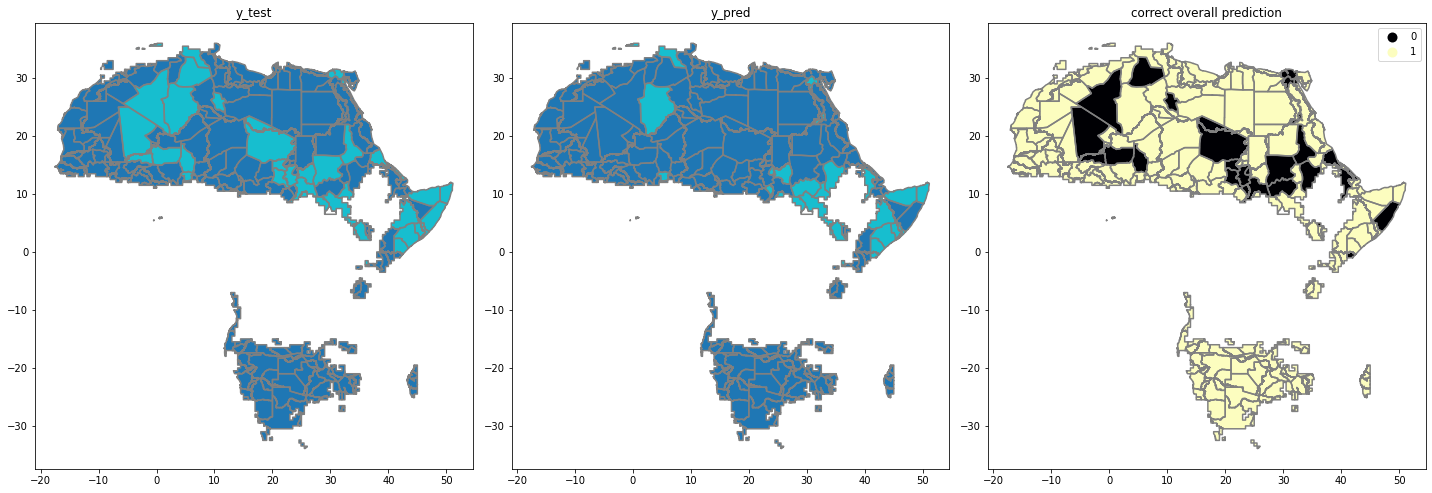

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
y_gdf.plot(ax=axes[0], column='y_test')
extent_active_polys_gdf.boundary.plot(ax=axes[0], color='0.5')
axes[0].set_title('y_test')
y_gdf.plot(ax=axes[1], column='y_pred')
extent_active_polys_gdf.boundary.plot(ax=axes[1], color='0.5')
axes[1].set_title('y_pred')
y_gdf.plot(ax=axes[2], column='overall_hit', cmap='magma', categorical=True, legend=True)
axes[2].set_title('correct overall prediction')
extent_active_polys_gdf.boundary.plot(ax=axes[2], color='0.5')
plt.tight_layout();

In [18]:
print("Accuracy: {0:0.3f}".format(metrics.accuracy_score(y_df.y_test.to_list(), y_df.y_pred.to_list())))
print("Precision: {0:0.3f}".format(metrics.precision_score(y_df.y_test.to_list(), y_df.y_pred.to_list())))
print("Recall: {0:0.3f}".format(metrics.recall_score(y_df.y_test.to_list(), y_df.y_pred.to_list())))
print('F1 score: {0:0.3f}'.format(metrics.f1_score(y_df.y_test.to_list(), y_df.y_pred.to_list())))
print('Cohen-Kappa score: {0:0.3f}'.format(metrics.cohen_kappa_score(y_df.y_test.to_list(), y_df.y_pred.to_list())))

Accuracy: 0.898
Precision: 0.708
Recall: 0.520
F1 score: 0.599
Cohen-Kappa score: 0.542


All other print-statements and plots in the output folder!

In [19]:
df_hit, gdf_hit = conflict_model.evaluation.get_average_hit(y_df, global_df)

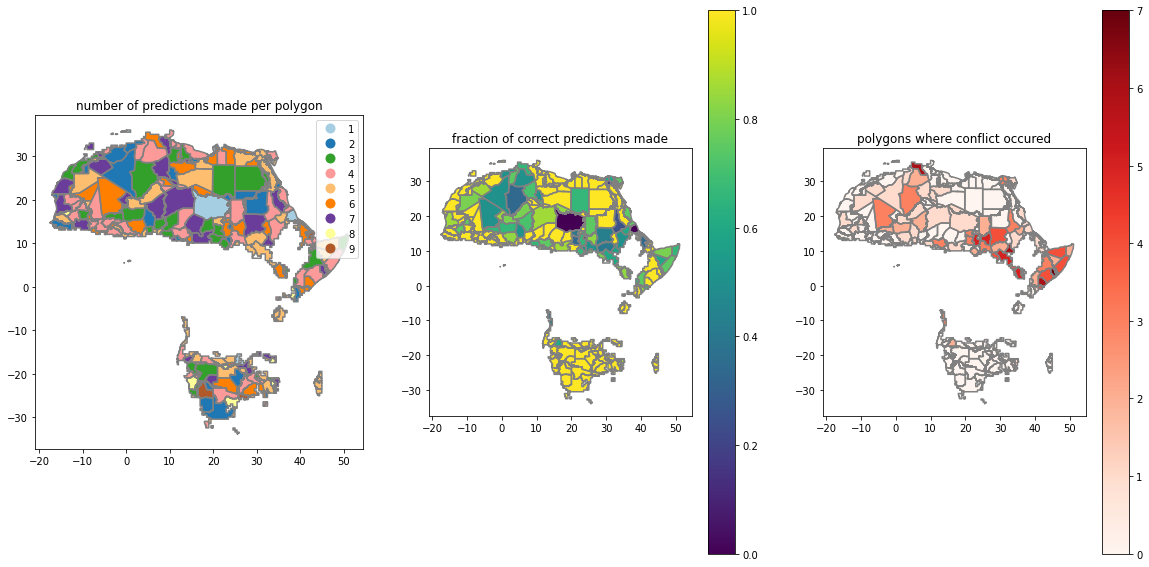

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
gdf_hit.plot(ax=ax1, column='ID_count', legend=True, cmap='Paired', categorical=True)
extent_active_polys_gdf.boundary.plot(ax=ax1, color='0.5')
ax1.set_title('number of predictions made per polygon')
gdf_hit.plot(ax=ax2, column='average_hit', legend=True, figsize=(20,10))
extent_active_polys_gdf.boundary.plot(ax=ax2, color='0.5')
ax2.set_title('fraction of correct predictions made')
gdf_hit.plot(ax=ax3, column='nr_of_test_confl', legend=True, cmap='Reds')
extent_active_polys_gdf.boundary.plot(ax=ax3, color='0.5')
ax3.set_title('polygons where conflict occured')
plt.savefig(os.path.join(out_dir, 'average_hit_precision.png'), dpi=300);

In [27]:
print('{0:0.2f} % of all active polygons are considered in test sample'.format(len(gdf_hit)/len(extent_active_polys_gdf)*100))

96.35 % of all active polygons are considered in test sample
